<a href="https://colab.research.google.com/github/Hf301/Hf301/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

С помощью CNN решаем задачу множественной классификации изображений, в качестве данных датасет CIFAR-10.

In [ ]:
import torch
import torch.nn as nn
import torchvision
from collections import defaultdict
import time
from torchsummary import summary
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

device_num = 0
device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cpu


1) **Cоздаем класс сети**

In [ ]:
# import torch.nn.functional as F

# class MyCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.do1 = nn.Dropout(0.2)  # 20% Probability
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.do2 = nn.Dropout(0.2)  # 20% Probability
#         self.fc2 = nn.Linear(120, 84)
#         self.do3 = nn.Dropout(0.1)  # 10% Probability
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.do1(x)
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = self.do2(x)
#         x = F.relu(self.fc2(x))
#         x = self.do3(x)
#         x = self.fc3(x)
#         return x


# model = MyCNN()
# model.to(device)

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(            
          # Блок 1: Свёртка с большим ядром, чтобы уловить общие закономерности
          nn.Conv2d(3, 16, kernel_size=5, padding=2),
          # Батч-нормализация всегда идёт до функции активации.
          nn.BatchNorm2d(16),
          nn.MaxPool2d(2),
          nn.Dropout(0.05),

          # Блок 2: Свёртка с ядром поменьше, выделяет более тонкие признаки.
          nn.Conv2d(16, 32, kernel_size=3, padding=1),
          nn.BatchNorm2d(32),
          nn.MaxPool2d(2),
          # Дропаут идёт после функции активации.
          nn.Dropout(0.05)
        )

        self.classifier = nn.Sequential(
          # Блок 3: Линейный слой поверх карт активации.
          nn.Linear(2048, 512),
          nn.BatchNorm1d(512),
          nn.ReLU(),
          nn.Dropout(0.05),

          # Блок 4: Классификационный слой.
          nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Переносим CNN на device
model = MyCNN().to(device)
 

In [ ]:
model

MyCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.05, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.05, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
# загружаем тренировочный датасет CIFAR10
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
print(np.unique(dataset.targets))

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
#Размер всего датасета
print(dataset.data.shape)

(50000, 32, 32, 3)


In [ ]:
#Делим датасет на тренировочную и тестовую части
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [45000, 5000]
)

In [ ]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_loader = test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

**Обучение**

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=20
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Так как это не обучающие батчи, градиент не нужен
            with torch.no_grad():
                logits = model(X_batch)
                
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

*** Графики обучения.

Epoch 20 of 20 took 42.978s
  training loss (in-iteration): 	0.570750
  validation loss (in-iteration): 	0.906058
  training accuracy: 			81.24 %
  validation accuracy: 			68.32 %


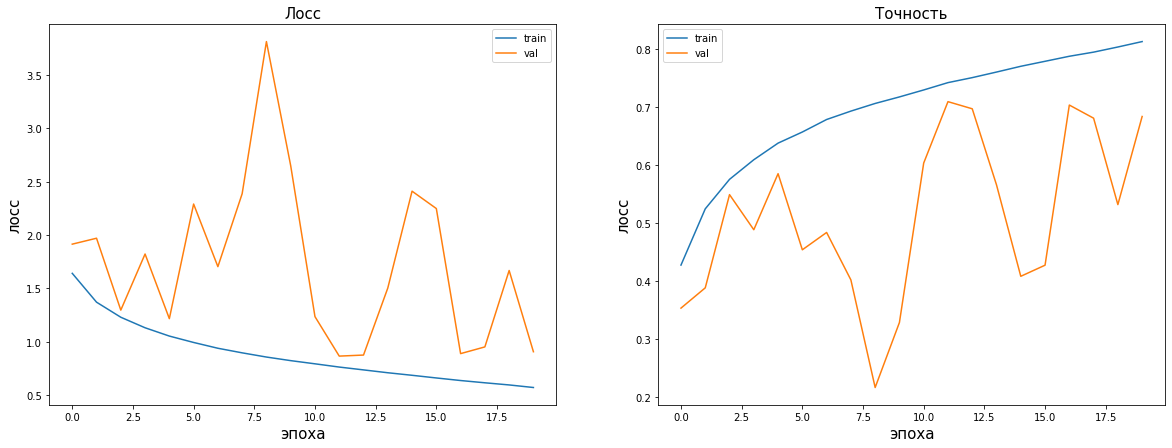

In [ ]:
# Зададим функциию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Обучим модель
model, history = train(
    model, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=20
)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
with torch.no_grad():
  output = model(example_data.to(device))

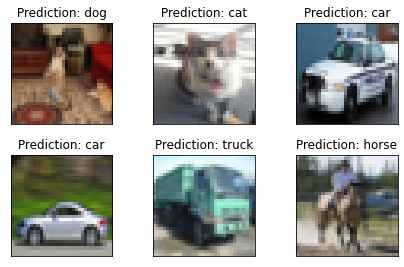

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(np.transpose(example_data[i], (1, 2, 0)), interpolation='none')
  plt.title(f"Prediction: {classes[output.data.max(1, keepdim=True)[1][i].item()]}")
  plt.xticks([])
  plt.yticks([])